# Распознавание ключевых слов: использование речевых формант в качестве входных параметров модели 

Пример ноутбука, распознающего слова "down", "go", "left", "no", "right", "stop", "up", "yes", используя форманты в качестве фичей

## Установка библиотек

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from sklearn import preprocessing as skl_prepr

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

import python_speech_features as psf

from pydub import AudioSegment

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
print(tf.__version__, np.__version__)

2.7.0 1.19.5


## Импорт датасета Google Speech Commands

Используется малый датасет для настройки алгоритма

In [3]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182091776/182082353 [==============================] - 4s 0us/step


In [4]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


Shuffle файлов

In [5]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data\\mini_speech_commands\\stop\\bc065a17_nohash_1.wav', shape=(), dtype=string)


Train/test/validate-split

In [6]:
train_ex = 6400
test_ex = 800
val_ex = 800

train_files = filenames[:train_ex]
val_files = filenames[train_ex : train_ex + test_ex]
test_files = filenames[train_ex + test_ex : train_ex + test_ex + val_ex]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


## Заливка аудиофайлов

In [7]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [8]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2] 

In [9]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

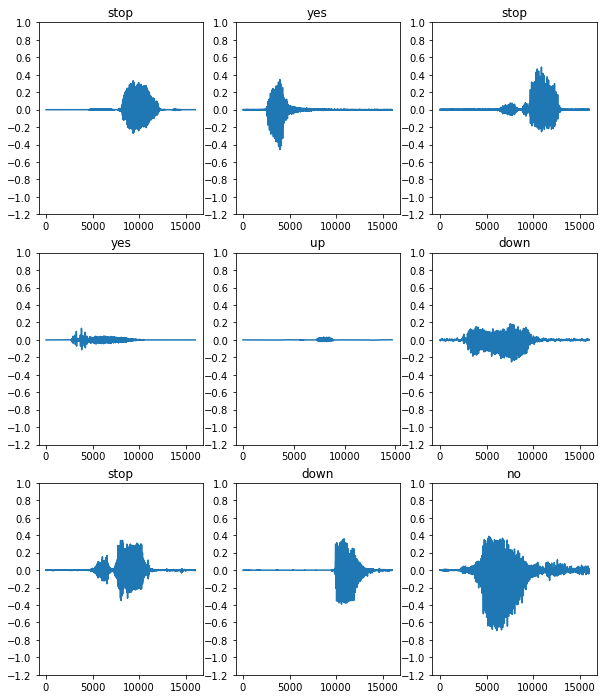

In [11]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

## Спектрограммы

Блок с исследованием спектрограмм сигналов

In [12]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [13]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)


print(tf.shape(waveform))

d = tf.shape(waveform)
test = tf.cast(AudioSegment.silent(duration = (16000 - d) * 1000 / 22050, frame_rate = 22050).get_array_of_samples(), tf.float32)

print(test.shape)

waveform = tf.cast(waveform, tf.float32)
wp = tf.concat([waveform, test], 0)

print(tf.shape(wp))

wp = tf.cast(wp, tf.float32)



tf.Tensor([16000], shape=(1,), dtype=int32)
(0,)
tf.Tensor([16000], shape=(1,), dtype=int32)


In [14]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: stop
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [15]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

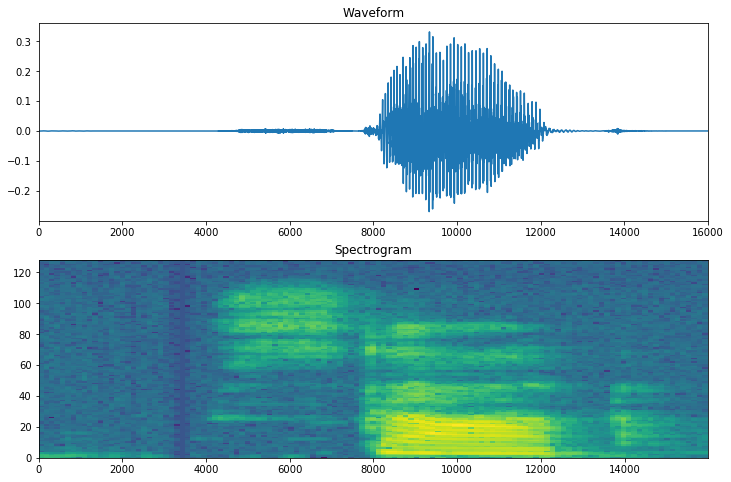

In [16]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [17]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [18]:
formant_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

Спектрограммы различных сигналов + паддинг

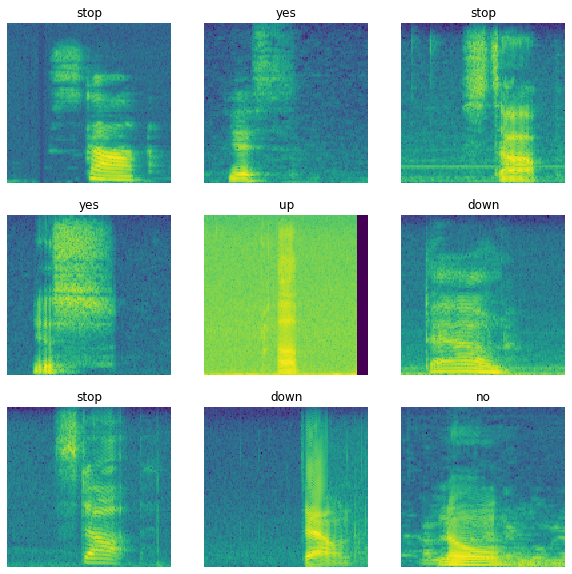

In [19]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(formant_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

## Форманты и MFCC

Препроцессинг пайплайн - извлечение 6 (далее - N)

In [20]:
def pad_wave(waveform, length_to_pad):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = length_to_pad
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  
  return equal_length

In [22]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  feat_ = psf.mfcc(pad_wave(waveform, 16000), samplerate = 22050, winlen = 0.02, winstep = 0.01, nfft = 512)
  print(label, feat_[:1])


print(feat_.shape)
arr = feat_[:1]
print(arr.shape, arr)

ind = np.argpartition(arr, -3)

arr_out = np.zeros(arr.flatten().shape)

print(arr_out.shape)

ind_norm = ind[0, -3:]

print(ind_norm, arr.flatten()[ind_norm])

arr_out.put(ind_norm, arr.flatten()[ind_norm])


# 2do - add normalization
# print(ind.shape, ind[0, -3:], arr_max, '\n flattened array \n', np.concatenate([ind_norm, arr_max]).shape, '\n res \n', arr_out) 
#
# , '\n only max \n', arr_out)

  # .argpartition - находит максимальные значения

stop [[-15.7689988  -17.16765028  19.16769031  19.47966158  18.0689335
   19.1570957   17.87111919  15.46766191   4.20735757   5.62908055
    7.15382755  -2.13668588  -9.87669503]]
(72, 13)
(1, 13) [[-15.7689988  -17.16765028  19.16769031  19.47966158  18.0689335
   19.1570957   17.87111919  15.46766191   4.20735757   5.62908055
    7.15382755  -2.13668588  -9.87669503]]
(13,)
[5 2 3] [19.1570957  19.16769031 19.47966158]


In [23]:
def extract_formants(array):
    #print(array.shape)
    ind = np.argpartition(array, -6)[-6:]
    #print(ind, ind.shape, type(ind))
    arr_out = np.zeros(array.flatten().shape)
    arr_out.put(ind, array.flatten()[ind])
    return arr_out

In [24]:
def primitive_formants_features(waveform, label):
    #print(type(waveform), waveform.shape)
    inp_arr = waveform.numpy()
    #print(type(inp_arr), inp_arr.shape)
    features_init = psf.mfcc(pad_wave(inp_arr, 16000), samplerate = 22050, winlen = 0.02, winstep = 0.01, nfft = 512, numcep=26)
    #print(type(features_init), features_init.shape)
    features = tf.convert_to_tensor(np.apply_along_axis(extract_formants, 1, features_init), dtype=tf.float32)
    
    label_id = tf.argmax(label == commands)
    #print('label_id : ', label_id, ' features : ', features.shape)
    del inp_arr, features_init

    return features, label_id

In [25]:
for waveform, label in files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE).take(1):
  label = label.numpy().decode('utf-8')
  feat_ = psf.mfcc(pad_wave(waveform, 16000), samplerate = 22050, winlen = 0.02, winstep = 0.01, nfft = 512, numcep=26)
  
  f_, l_ = primitive_formants_features(waveform, label)
  print(f_.shape, l_.shape)




(72, 26) ()


In [26]:
def outside_function(waveform, label):
    wv, lbl = tf.py_function(func = primitive_formants_features, inp = [waveform, label], Tout = [tf.float32, tf.int64])
    wv = tf.reshape(wv, shape=(1872,))
    return wv, lbl


In [27]:
for waveform, label in files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE).take(1):
  wv, label_ = outside_function(waveform, label)
  print(wv.shape, label_)

# layer = tf.keras.layers.Reshape(target_shape = (432,))

# output = layer(wv)
# print(output.shape)

(1872,) tf.Tensor(5, shape=(), dtype=int64)


## Определение функции препроцессинга + заливка данных

In [28]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label)
  output_ds = output_ds.map(outside_function)
  #output_ds = output_ds.map(fix_shape_)
  return output_ds

In [29]:
train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

whole_ds = preprocess_dataset(filenames)

In [30]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [31]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [32]:
print(train_ds.take(1))


<TakeDataset shapes: ((None, 1872), <unknown>), types: (tf.float32, tf.int64)>


Модель - fully-connected Dense-слои

In [33]:
#del model

In [34]:
for elem, _ in whole_ds.take(1):
  input_shape = elem.shape
print('Input shape:', input_shape)
num_labels = len(commands)
print(num_labels)

# Instantiate the `tf.keras.layers.Normalization` layer.
# norm_layer = layers.Normalization()
# norm_layer.adapt(data=whole_ds.map(map_func=lambda spec, label: spec))


Input shape: (1872,)
8


In [35]:

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Dense(432, activation='relu', name = 'dense_init'),
    layers.Dropout(0.1),
    layers.Dense(256, activation='relu', name = 'dense_256'),
    layers.Dropout(0.15),
    layers.Dense(128, activation='relu', name = 'dense_128'),
    layers.Dropout(0.15),
    layers.Dense(64, activation='relu', name = 'dense_64'),
    layers.Dropout(0.15),
    layers.Dense(num_labels, activation = 'softmax', name = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_init (Dense)          (None, 432)               809136    
                                                                 
 dropout (Dropout)           (None, 432)               0         
                                                                 
 dense_256 (Dense)           (None, 256)               110848    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_128 (Dense)           (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_64 (Dense)            (None, 64)                8

In [36]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=tf.keras.metrics.CategoricalAccuracy()
)

In [37]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 [==============================] - 64s 616ms/step - loss: 2.0636 - categorical_accuracy: 0.0883 - val_loss: 1.6681 - val_categorical_accuracy: 0.0562
Epoch 2/10
100/100 [==============================] - 1s 11ms/step - loss: 1.5882 - categorical_accuracy: 0.0817 - val_loss: 1.4649 - val_categorical_accuracy: 0.0637
Epoch 3/10
100/100 [==============================] - 1s 11ms/step - loss: 1.3220 - categorical_accuracy: 0.0853 - val_loss: 1.3526 - val_categorical_accuracy: 0.0688
Epoch 4/10
100/100 [==============================] - 1s 13ms/step - loss: 1.1232 - categorical_accuracy: 0.0855 - val_loss: 1.3636 - val_categorical_accuracy: 0.0750
Epoch 5/10
100/100 [==============================] - 1s 13ms/step - loss: 0.9057 - categorical_accuracy: 0.0866 - val_loss: 1.2414 - val_categorical_accuracy: 0.0787
Epoch 6/10
100/100 [==============================] - 1s 13ms/step - loss: 0.7224 - categorical_accuracy: 0.0831 - val_loss: 1.2411 - val_categorical_accuracy: 0.0

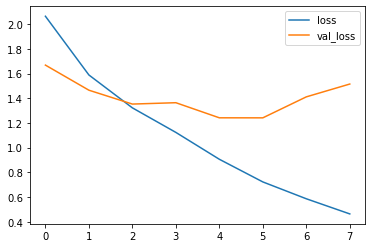

In [38]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

## Перформанс на тестовом датасете


In [39]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [40]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 61%


### Confusion matrix


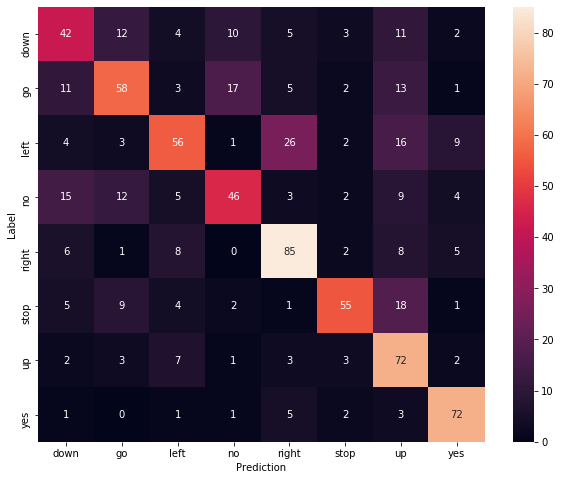

In [41]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Применение модели

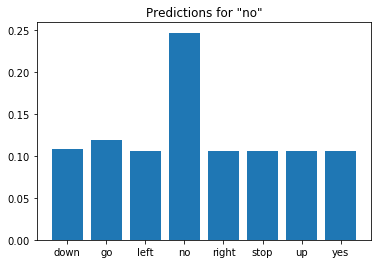

In [42]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()